In [ ]:
# ! pip install -r requirements.txt
# ! playwright install

In [2]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from langgraph.graph import MessagesState, START, END, StateGraph
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from playwright.async_api import Browser, BrowserContext, Page, async_playwright, Playwright
import asyncio
import os

In [12]:
from agent import RT_Graph

In [22]:
async def run(playwright: Playwright):
    chromium = playwright.chromium # or "firefox" or "webkit".
    browser = await chromium.launch(headless=False)
    
    browser_context = await browser.new_context()
    page = await browser_context.new_page()
    await page.goto("https://reddit.com")

    # Kick off the DAG
    graph = RT_Graph()
    graph.set_page(page)
    agent = graph.compile()
    
    await agent.ainvoke({
        "selected_element" : "",
        "context_html" : "",
        "context_img" : "",
        "messages" : [],
    })


    # wait 10 secs
    await asyncio.sleep(120)
    await browser_context.close()
    await browser.close()
    

async def main():
    async with async_playwright() as playwright:
        await run(playwright)


await main()

page:  <Page url='https://www.reddit.com/?rdt=54398'>
set selected element:  body
ans:  False
no tool call
waiting
page:  <Page url='https://www.reddit.com/?rdt=54398'>
set selected element:  reddit-search-large
ans:  False
no tool call
waiting
page:  <Page url='https://www.reddit.com/r/TIHI/comments/glb16s/thanks_i_hate_hello_kitty/'>
set selected element:  body
ans:  False
no tool call
waiting
page:  <Page url='https://www.reddit.com/r/TIHI/comments/glb16s/thanks_i_hate_hello_kitty/'>
set selected element:  pdp-comment-search-input
ans:  True
THIS IS A MESSAGE BOX
waiting
page:  <Page url='https://www.reddit.com/r/TIHI/comments/glb16s/thanks_i_hate_hello_kitty/'>
set selected element:  pdp-comment-search-input
ans:  True
THIS IS A MESSAGE BOX
waiting
page:  <Page url='https://www.reddit.com/r/TIHI/comments/glb16s/thanks_i_hate_hello_kitty/'>
set selected element:  button
ans:  False
no tool call
waiting


CancelledError: 

In [15]:
class RT_State(TypedDict):
    selected_element: str
    context_html : str
    context_img : str
    messages : MessagesState
    page : object

chat = ChatOpenAI(model="gpt-4o-mini", temperature=0, api_key=os.getenv("OPENAI_API_KEY"))

def set_selected_element(state : RT_State):
    """ Sets the tag name of the element currently selected by the mouse om the selected_element field of the state """
    print("set selected element")
    if isinstance(state['page'], Page):
        hover_element = state['page'].locator(':hover')
        selected_elem = hover_element.evaluate('e => e.tagName')
        state['selected_element'] = selected_elem
    return state

@tool
def set_context_html(state : RT_State):
    """ Sets the inner html of the element currently selected by the mouse on the context_html field of the state """
    print("get context html")
    if  isinstance(state['page'], Page):
        context_html = state['page'].evaluate('document.querySelector(":hover").innerHTML')
        state['context_html'] = context_html
        state['messages'].append(SystemMessage(content=f"Here is the inner html of the element: {context_html}"))
    return state

@tool
def set_context_img(state : RT_State):
    """ Sets the image of the element currently selected by the mouse on the context_img field of the state """
    print("get context img")
    if isinstance(state['page'], Page):
        context_img = state['page'].screenshot()
        # pass thru an LLM to describe the image
        state['context_img'] = context_img
        state['messages'].append(SystemMessage(content=f"Here is the description of the image of the element: {context_img}"))
    return state
    
def decide_if_selected_is_message_box(state : RT_State):
    """ Decides if the selected element is a message box using an LLM with access to tools (set_context_html, set_context_img) """
    state['messages'].append(
        SystemMessage(content="""
            Is the selected element a message box?, You are an agent being used to translate a message as its being typed in a message box.
            You need to decide if the selected element is a message box. You have may have access to the following information:
            Name of the selected element: {selected_element}
                  
            You have the following tools at your disposal:
            set_context_html - to find the html of the page if you don't have it yet
            set_context_img - to find the screenshot of the page if you don't have it yet
                  
            If you think the selected element is a message box, return True. 
            If you think you need to use a tool, return the name of the tool
            Otherwise, return False.
    """.format(selected_element=state['selected_element']))
    )
    state['messages'].append(
        HumanMessage(content="Is the selected element a message box?")
    )
    ans = chat.invoke(state['messages'])
    state['messages'].append(ans)
    return state

def cond_edge_is_messbox(state : RT_State):
    if state['messages'][-1].tool_calls:
        print("tool call")
        return state['messages'][-1].tool_calls[0].name
    else:
        print("no tool call")
        return "wait"

async def handle_wait(state : RT_State):
    """ Waits for 10 seconds and returns the state """
    print("waiting")
    await asyncio.sleep(10)
    return state


In [89]:
chat = chat.bind_tools([set_context_html, set_context_img])

In [80]:
from langchain_core.prompts.chat import ChatPromptTemplate

p_state = RT_State(
    selected_element = "",
    context_html = "",
    context_img = "",
    messages = []
)

p_state['messages'].append(
    SystemMessage(content="""
            Is the selected element a message box?, You are an agent being used to translate a message as its being typed in a message box.
            You need to decide if the selected element is a message box. You have may have access to the following information:
            Name of the selected element: {selected_element}
                  
            You have the following tools at your disposal:
            set_context_html - to find the html of the page if you don't have it yet
            set_context_img - to find the screenshot of the page if you don't have it yet
                  
            If you think the selected element is a message box, return True. 
            If you think you need to use a tool, return the name of the tool
            Otherwise, return False.
    """.format(selected_element="glamorous_box"))
)

p_state['messages'].append(
    HumanMessage(content="Is the selected element a message box?")
)

ans = chat.invoke(p_state['messages'])
p_state['messages'].append(ans)

In [38]:
p_state['messages'][-1].tool_calls

[{'name': 'set_context_html',
  'args': {'page': {},
   'state': {'selected_element': 'glamorous_box',
    'context_html': '',
    'context_img': '',
    'messages': {'messages': []}}},
  'id': 'call_ffmlYtqAf2NyZJgc8umBLvLT',
  'type': 'tool_call'}]

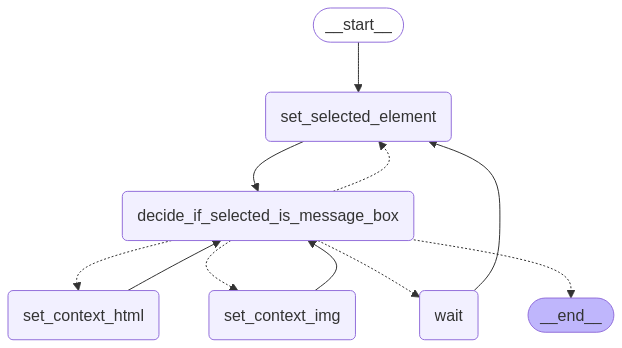

In [96]:
graph = StateGraph(RT_State)

graph.add_node("set_selected_element", set_selected_element)
graph.add_node("set_context_html", set_context_html)
graph.add_node("set_context_img", set_context_img)
graph.add_node("decide_if_selected_is_message_box", decide_if_selected_is_message_box)
graph.add_node("wait", handle_wait)

graph.add_edge(START, "set_selected_element")

graph.add_edge("set_selected_element", "decide_if_selected_is_message_box")
graph.add_edge("set_context_html", "decide_if_selected_is_message_box")
graph.add_edge("set_context_img", "decide_if_selected_is_message_box")
graph.add_conditional_edges(
    "decide_if_selected_is_message_box",
    cond_edge_is_messbox,
)
graph.add_edge("wait", "set_selected_element")
graph.compile()


In [98]:
agent = graph.compile()

await agent.ainvoke({
        "selected_element" : "",
        "context_html" : "",
        "context_img" : "",
        "messages" : [],
        "page" : "-"
        
})

set selected element
no tool call
waiting
set selected element
no tool call
waiting


CancelledError: 